try multi label margin loss on 10-class mnist classification task:

the network output is $y(0),\dots, y(i),\dots, y(9)$, the one-hot label of is $\hat y(0)\dots,\hat y(i),\dots,\hat y(9)$.  

the loss function is $\sum_{i = 0}^9\max(0, u - y(i) \hat y(i))$. 

one hot label are either $-1$ or $+1$

if $y(i) > 0, \hat y(i) = +1$, then $\max(0, u - y(i) \hat y(i)) = \max(0, u - y(i))$, $y(i)$ has to be at least as large as $u$. 

if $y(i) < 0, \hat y(i) = -1$, then $y(i)$ has to be as negative as $-u$.

In [2]:
from training import * 
from network import *

def multiHingeLoss(output, target, margin = 1):
    # output: (batch_size, num_classes)
    # target: (batch_size, num_classes)
    # loss: (batch_size, 1)
    loss = torch.clamp(margin - output * target, min=0)
    return loss.sum(dim=1).mean()

def oneHotLabel(label, num_classes):
    # label: (batch_size, 1)
    # one_hot_label: (batch_size, num_classes)
    batch_size = label.size(0)
    one_hot_label =(-torch.ones(batch_size, num_classes)).scatter_(1, label.view(-1, 1), 1)
    return one_hot_label

def train_models_NN(model, 
                trainloader, 
                testloader,
                regularization = 0.0,
                H = 20, 
                in_dim = 28, 
                out_dim = 10, 
                num_epochs = 20,
                verbose = True, 
                device = torch.device('cpu'),
                model_type = 'parallel'): 
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses, acc = [], []
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            if model_type == 'parallel':
                with torch.no_grad():
                    slope_thres = 0.01
                    mask = (model.parallel_synapse.slope.data < slope_thres) 
                    model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = slope_thres)
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    
                    ampli_thres = 0.1
                    mask = (model.parallel_synapse.ampli.data**2 < ampli_thres) 
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    model.parallel_synapse.ampli.data[mask] = np.sqrt(ampli_thres)
                    
                    model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, min = model.hidden_range[0] )
            
            inputs = inputs.view(-1, 28*28).to(device)
            labels = oneHotLabel(labels, out_dim).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = multiHingeLoss(outputs, labels) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(trainloader))
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = oneHotLabel(labels, out_dim).to(device)
                outputs = model(inputs)
                total += labels.size(0)
                correct += torch.argmax(outputs, dim = 1).eq(torch.argmax(labels, dim = 1)).sum().item()
        acc.append(100 * correct / total )
        if verbose and epoch % 10 == 0:
            print( f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {acc[-1]:.2f}%")
    
    return {
            'model': model,
            'accuracy': acc,
            'loss': losses
            }
class TwoLayerNN(nn.Module):
    '''
    two layered neural network
    '''
    def __init__(self, 
                input_dim: int, 
                hidden_dim: int, 
                output_dim: int) -> None:
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        x = self.fc1(input)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
# get hidden activation with MNIST inputs
def get_hidden_final_activation_2NN(model, testloader):
    model.eval()
    hidden, final = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 28*28).to(device)
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu().numpy())
            final.append(model.fc2(torch.relu(model.fc1(inputs))).detach().cpu().numpy())
    return np.concatenate(hidden, axis=0), np.concatenate(final, axis=0)

In [17]:
import pickle
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

hidden_dim = 30
output_dim = 10
input_dim = 28*28
result = []
for i in range(10):
    torch.manual_seed(i)
    model = TwoLayerNN(input_dim, hidden_dim, output_dim)
    result.append(train_models_NN(model, trainloader, testloader, num_epochs = 80, verbose = True, model_type = '2nn'))
    
    with open('result_2nn.pickle', 'wb') as f:
        pickle.dump(result, f)
    
    print('--------------------------------------------------')

 Epoch 1/80, Loss: 1.1101, Accuracy: 89.04%
 Epoch 11/80, Loss: 0.5461, Accuracy: 91.34%
 Epoch 21/80, Loss: 0.5048, Accuracy: 92.05%
 Epoch 31/80, Loss: 0.4883, Accuracy: 92.04%
 Epoch 41/80, Loss: 0.4801, Accuracy: 91.79%
 Epoch 51/80, Loss: 0.4758, Accuracy: 92.25%
 Epoch 61/80, Loss: 0.4713, Accuracy: 92.54%
 Epoch 71/80, Loss: 0.4683, Accuracy: 91.96%
--------------------------------------------------
 Epoch 1/80, Loss: 1.2443, Accuracy: 85.67%
 Epoch 11/80, Loss: 0.6368, Accuracy: 90.19%
 Epoch 21/80, Loss: 0.5988, Accuracy: 90.53%
 Epoch 31/80, Loss: 0.5676, Accuracy: 90.63%
 Epoch 41/80, Loss: 0.5504, Accuracy: 91.01%
 Epoch 51/80, Loss: 0.5369, Accuracy: 90.66%
 Epoch 61/80, Loss: 0.5301, Accuracy: 91.10%
 Epoch 71/80, Loss: 0.5273, Accuracy: 91.20%
--------------------------------------------------
 Epoch 1/80, Loss: 0.8015, Accuracy: 90.87%
 Epoch 11/80, Loss: 0.3005, Accuracy: 94.67%
 Epoch 21/80, Loss: 0.2689, Accuracy: 94.87%
 Epoch 31/80, Loss: 0.2505, Accuracy: 95.13%
 

In [5]:
hidden, final = get_hidden_final_activation_2NN(model, testloader)

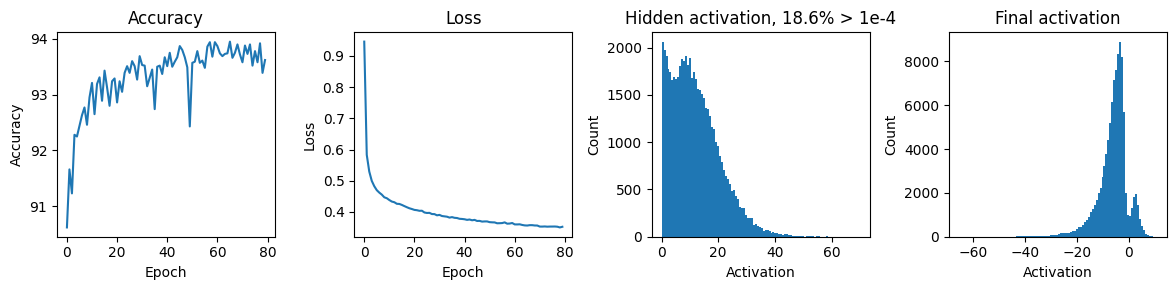

In [6]:
# plot histogram of hidden activation
plt.figure(figsize=(12, 3)) 
plt.subplot(1,4,3)
plt.hist(hidden[hidden>0.00001].flatten(), bins=100)
plt.title('Hidden activation, {:.1f}% > 1e-4'.format((hidden>1e-4).mean() * 100))
plt.xlabel('Activation')
plt.ylabel('Count')
plt.subplot(1,4,4)
plt.hist(final.flatten(), bins=100)
plt.title('Final activation')
plt.xlabel('Activation')
plt.ylabel('Count')
plt.subplot(1, 4, 2)
plt.plot(result['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.subplot(1, 4, 1)
plt.plot(result['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.tight_layout()
plt.show()

Replace final layer with parallel synapses

In [3]:
class ParallelSynapseLayer_FlipSign(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                output_dim: int, 
                input_range: Tuple = (-1, 1)) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.n_synapse = n_synapse
        self.output_dim = output_dim
        
        self.thres = nn.Parameter(torch.rand(
            self.n_synapse, self.input_dim, self.output_dim) * (input_range[1] - input_range[0]) + input_range[0])
        self.slope = nn.Parameter(5*torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.ampli = nn.Parameter(torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.scaler = nn.Parameter(torch.rand(self.input_dim, self.output_dim))
        
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        n_data = input.shape[0]
        x = self.slope[None, :, :,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            (input[:, None, :, None].expand(n_data, self.n_synapse, self.input_dim, self.output_dim)
            - self.thres[None, :,:,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim))
        x = (self.ampli[None, :, :,:]**2).expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            torch.tanh(x) 
        x = x.sum(dim=(1)).squeeze()
        x = x * self.scaler[None, :, :].expand(n_data, self.input_dim, self.output_dim)
        x = x.sum(dim=(1)).squeeze() 
        return x

class ParallelSynapse2NN_FixLayer1(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                hidden_dim: int, 
                weight: torch.Tensor,
                bias: torch.Tensor,
                output_dim: int = 10, 
                hidden_range: Tuple = (0, 40)) -> None:
        super().__init__()
        self.hidden_range = hidden_range
        
        self.fc1 = nn.Linear(hidden_dim, input_dim)
        
        assert weight.shape == (hidden_dim, input_dim)
        assert bias.shape == (hidden_dim,)
        assert output_dim == 10
        
        self.fc1.weight.data = weight
        self.fc1.bias.data = bias
        self.fc1.weight.requires_grad_(False)
        self.fc1.bias.requires_grad_(False) 
        self.parallel_synapse = ParallelSynapseLayer_FlipSign(hidden_dim, 
                                                n_synapse, 
                                                output_dim, 
                                                input_range = self.hidden_range)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.parallel_synapse(x)
        return x.squeeze()
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(12, 3))
    plt.subplot(1,4,1)
    plt.hist((model.parallel_synapse.ampli.data.cpu().numpy()**2).flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,4,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,4,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')
    
    plt.subplot(1,4,4)
    plt.hist(model.parallel_synapse.scaler.data.cpu().numpy().flatten(), bins=20)
    plt.title('Scaler histogram')
    
    plt.tight_layout()
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        labels = binary_labels(labels)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    plt.title('Histogram, hidden layer input')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, hidden.data.cpu().numpy().flatten().max(), steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
    x = x - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    x = x * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    
    print(input.shape, x.shape)
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize = (10, 4)) 
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(input[:,0].numpy(), x.detach().numpy()[:,:,i], alpha = 0.8)
        plt.title('output-' + str(i+1))
        plt.xlabel('Input')
    plt.tight_layout()
    # plt.title('Aggregate synaptic output')
    

In [5]:
import pickle
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
input_dim = 28*28
n_synapse = 3
hidden_dim = 30
with open('result_2nn.pickle', 'rb') as f:
    results = pickle.load(f)
result2 =[]
for i in range(10):
    model = results[i]['model']
    weight = model.fc1.weight.data.cpu()
    bias = model.fc1.bias.data.cpu()
    output_dim = 10
    hidden_range = (0, 15)

    model2 = ParallelSynapse2NN_FixLayer1(
        input_dim, 
        n_synapse, 
        hidden_dim, 
        weight, 
        bias, 
        output_dim, 
        hidden_range
    )
    result2.append( train_models_NN(model2, trainloader, testloader, num_epochs = 80, verbose = True, regularization=0))
    with open('result_parallel_freeze.pickle', 'wb') as f:
        pickle.dump(result2, f)

 Epoch 1/80, Loss: 1.9451, Accuracy: 87.26%
 Epoch 11/80, Loss: 0.5097, Accuracy: 89.40%
 Epoch 21/80, Loss: 0.4678, Accuracy: 91.15%
 Epoch 31/80, Loss: 0.4622, Accuracy: 91.42%
 Epoch 41/80, Loss: 0.4582, Accuracy: 91.48%
 Epoch 51/80, Loss: 0.4563, Accuracy: 91.65%
 Epoch 61/80, Loss: 0.4559, Accuracy: 91.34%
 Epoch 71/80, Loss: 0.4557, Accuracy: 91.60%
 Epoch 1/80, Loss: 2.2053, Accuracy: 84.64%
 Epoch 11/80, Loss: 0.4899, Accuracy: 89.81%
 Epoch 21/80, Loss: 0.4645, Accuracy: 90.44%
 Epoch 31/80, Loss: 0.4567, Accuracy: 90.60%
 Epoch 41/80, Loss: 0.4547, Accuracy: 90.71%
 Epoch 51/80, Loss: 0.4538, Accuracy: 90.54%
 Epoch 61/80, Loss: 0.4529, Accuracy: 90.69%
 Epoch 71/80, Loss: 0.4525, Accuracy: 90.82%
 Epoch 1/80, Loss: 1.8078, Accuracy: 91.33%
 Epoch 11/80, Loss: 0.2229, Accuracy: 95.22%
 Epoch 21/80, Loss: 0.1979, Accuracy: 95.37%
 Epoch 31/80, Loss: 0.1883, Accuracy: 95.56%
 Epoch 41/80, Loss: 0.1828, Accuracy: 95.56%
 Epoch 51/80, Loss: 0.1796, Accuracy: 95.60%
 Epoch 61/80,

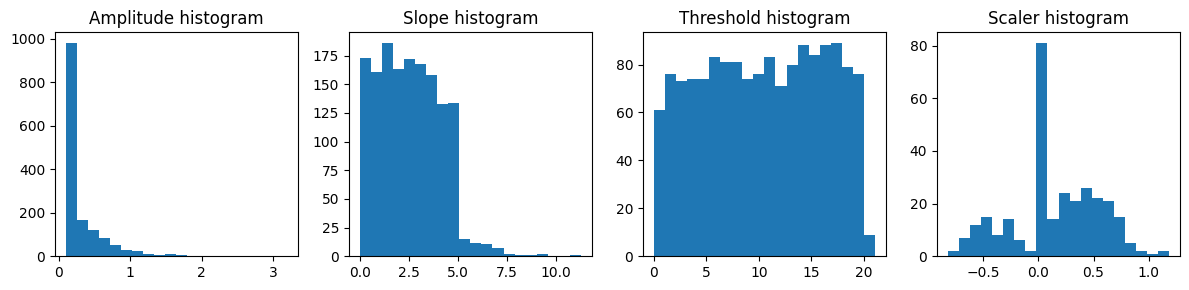

torch.Size([100, 30]) torch.Size([100, 30, 10])


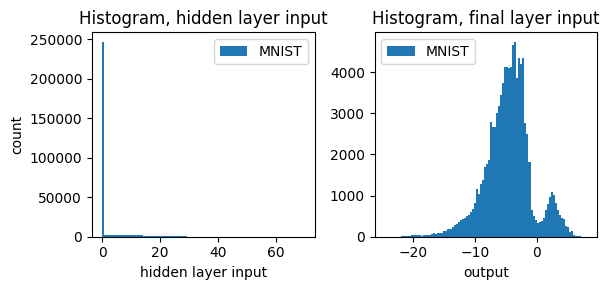

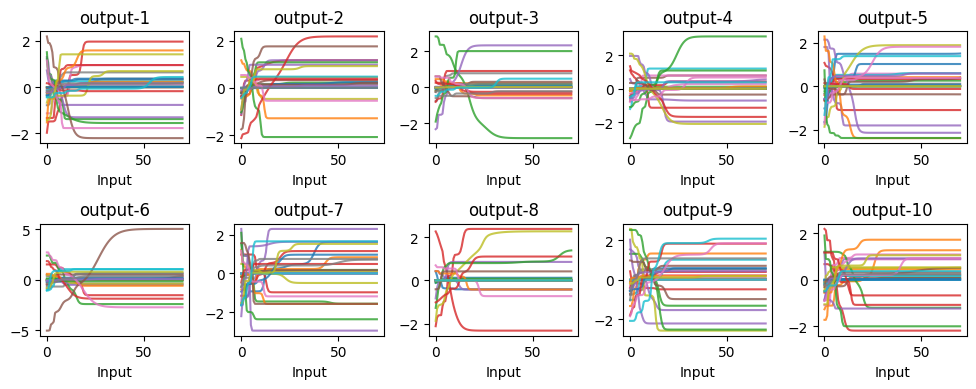

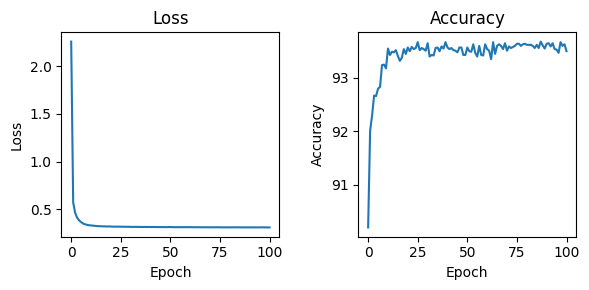

In [11]:
plot_parallel_synapse_params(model2)
plot_input_histogram_to_parallel_synapse_layer(model2, testloader, hidden_act='relu')
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.plot(result2['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(result2['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.tight_layout()
plt.show()

In [7]:
model_type = 'parallel'
loss_type = 'margin'
H = 10
M = 3
bias = 10
print(f'./results/{model_type}_{loss_type}_H{H}_M{M}_bias{bias}.pkl'  )

./results/parallel_margin_H10_M3_bias10.pkl
